# MIFS (demonstrated with a neural network)

### Raphael Steinborn

***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Dataset used from E-Learning course for demonstration:

__[Data set for exercise 4 (Wisconsin Breast Cancer, UCI](https://elearning.hnu.de/mod/resource/view.php?id=618189)__

In [2]:
df = pd.read_csv('wdbc.csv', delimiter=';')
df_train = pd.read_csv('wdbc_train.csv', delimiter=';')
df_test = pd.read_csv('wdbc_test.csv', delimiter=';')

#### Calculation of MI as outlined in Battiti, R. (1994)

Using formula (6) as stated in the paper for the calculation of Mutual Information.

In [3]:
def calc_mutual_information(x, y):
    # Calculate joint probability distribution between features x and class y
    joint_prob = pd.crosstab(x, y, normalize=True)
    # Calculate marginal probability distributions for x and y
    x_prob = x.value_counts(normalize=True)
    y_prob = y.value_counts(normalize=True)
    
    # Initialize mutual information sum
    mutual_info = 0
    # Iterate over all feature and class value combinations
    for f in x_prob.index:
        for c in y_prob.index:
            # Only add to sum if joint probability is non-zero to avoid log(0) error
            if joint_prob.at[f, c] > 0:
                # Increment mutual information by the contribution from the (f, c) pair
                mutual_info += joint_prob.at[f, c] * np.log2(joint_prob.at[f, c] / (x_prob[f] * y_prob[c]))
    return mutual_info

#### Implementation of the MIFS Algorithm, according to Battiti, R. (1994)

In [4]:
# Initialize Feature Selection

target = 'Malignant' # column we want to predict
features = df.drop(columns=[target]).columns.tolist() # holds features except the target
selected_features = [] # stores chosen features
remaining_features = features.copy() # tracks features that have not been selected

In [5]:
# Iterative Feature Selection

# Define the beta parameter, which balances between feature relevance and redundancy
beta = 0.5

# Begin process of feature (greedy) selection
while remaining_features:
    scores = {}
    
    # Calculate the MI for each feature with the target
    for feature in remaining_features:
        # MI between feature and target
        mi_feature_target = calc_mutual_information(df[feature], df[target])
        # Sum of MI with selected features
        mi_feature_selected = sum(calc_mutual_information(df[feature], df[selected]) for selected in selected_features)
        # The score used for feature selection
        scores[feature] = mi_feature_target - beta * mi_feature_selected

    # Identify the feature with the highest score and add it to selected list
    next_feature = max(scores, key=scores.get)
    selected_features.append(next_feature)
    remaining_features.remove(next_feature) # Removes the selected feature from the remaining list
    
    # Stop selecting features if desired number is reached
    if len(selected_features) == 3:  # Stops if reaches desired number of selected features
        break


In [6]:
# Print Selected Features
print("Selected Features:", selected_features)

Selected Features: ['ConcavePointsMean', 'RadiusWorst', 'SmoothnessWorst']


## Demonstration

#### ANN used for demonstration:

__[7 ann full](https://elearning.hnu.de/mod/resource/view.php?id=618192)__ , __[ann](https://elearning.hnu.de/mod/resource/view.php?id=618193)__ from Elearning course (Artificial neural networks and classification metrics)

In [7]:
# Methods required for ANN

# Define the logistic activation function to introduce non-linearity in the model
def logistic(x):
    return 1 / (1 + np.exp(-x))

# Define the derivative of the logistic function to calculate gradients during backpropagation
def logistic_derivative(x):
    return np.multiply(x, (1 - x))

# Perform forward propagation for a single layer of the network
def single_layer_forward_propagation(W, B, A_prev):
    Z = np.dot(W, A_prev) + B
    return logistic(Z)

# Set the parameters (weights and biases) for a given layer
def set_parameters(parameters, l, W, B):
    parameters["W" + str(l + 1)] = W
    parameters["b" + str(l + 1)] = B
    return parameters

# Get the parameters (weights and biases) for a given layer
def get_parameters(parameters, l):
    return parameters["W" + str(l + 1)], parameters["b" + str(l + 1)]

# Perform forward propagation routine for the ANN
def vectorized_forward_propagation(X, parameters):
    W1, B1 = get_parameters(parameters, 0)
    A1 = single_layer_forward_propagation(W1, B1, np.transpose(X))
    
    W2, B2 = get_parameters(parameters, 1)
    A2 = single_layer_forward_propagation(W2, B2, A1)
    return A1, A2

# Perform backpropagation to update the models parameters based on error
def vectorized_backward_propagation(X, y, A1, A2, parameters, alpha):
    m = X.shape[0]
    error = (A2 - y)

    W2, B2 = get_parameters(parameters, 1)
    W2_fixed = W2
    delta2 = np.multiply(logistic_derivative(A2), error)
    B2 = B2 - alpha * 2 / m * np.dot(delta2, np.ones((m,1)))
    W2 = W2 - alpha * 2 / m * np.dot(delta2, np.transpose(A1))
    parameters = set_parameters(parameters, 1, W2, B2)
    
    W1, B1 = get_parameters(parameters, 0)
    delta1 = np.multiply(logistic_derivative(A1), np.dot(np.transpose(W2_fixed), delta2))
    B1 = B1 - alpha * 2 / m * np.dot(delta1, np.ones((m,1)))
    W1 = W1 - alpha * 2 / m * np.dot(delta1, X)
    parameters = set_parameters(parameters, 0, W1, B1)
    
    return parameters

# Initialize weights of the network
def get_a(n_prev, n_next):
    return np.sqrt(2 / (n_prev + n_next))

# Initialize the weights of the ANN
def initialize_weights(X, hidden_neurons):
    parameters = {}
    a = get_a(X.shape[1], hidden_neurons)
    parameters["W1"] = np.random.uniform(size=(hidden_neurons,X.shape[1]), low=-a, high=a)
    parameters["b1"] = np.zeros((hidden_neurons,1))
    a = get_a(hidden_neurons, 1)
    parameters["W2"] = np.random.uniform(size=(1,hidden_neurons), low=-a, high=a)
    parameters["b2"] = np.zeros((1,1))
    return parameters

In [8]:
# Prepare Data for ANN
X_train = df_train[selected_features].values
y_train = df_train[target].values
X_test = df_test[selected_features].values
y_test = df_test[target].values

In [9]:
# Initialize and Train ANN:
parameters = initialize_weights(X_train, hidden_neurons=2) # Initializes the ANN weights
T = 10000 # Number of training iterations
alpha = 0.5 # Learning rate
loss = [] # List to track the loss values

# Start the training loop over number of iterations
for t in range(T):
    A1, A2 = vectorized_forward_propagation(X_train, parameters)
    l = np.sum((A2[0] - y_train)**2) / X_train.shape[0]
    loss.append(l)
    parameters = vectorized_backward_propagation(X_train, y_train, A1, A2, parameters, alpha=alpha)

***

## Plots

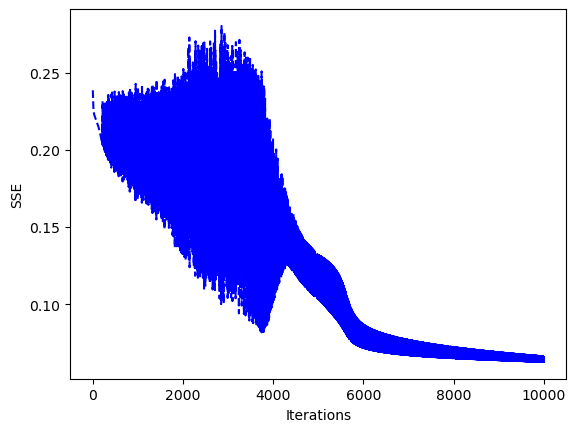

In [10]:
# Plot Sum of Squared Errors (SSE) loss for each iteration
plt.plot(range(len(loss)), loss, '--b')
plt.xlabel("Iterations")
plt.ylabel("SSE")
plt.show()

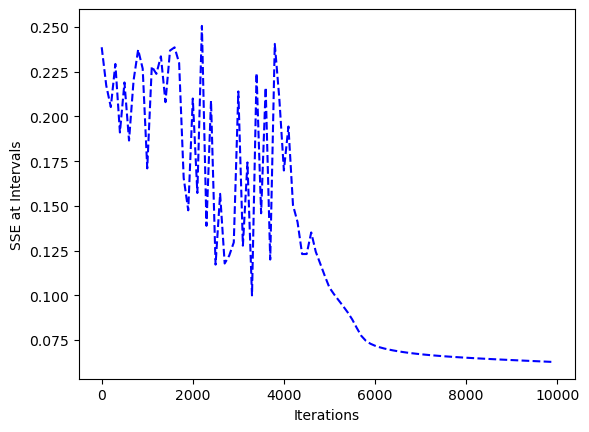

In [11]:
# Plot at Regular Intervals for better visibility
interval = 100
plt.plot(range(0, len(loss), interval), loss[::interval], '--b')
plt.xlabel("Iterations")
plt.ylabel("SSE at Intervals")
plt.show()

#### Observations:
The decreasing trend in loss suggests the ANN is learning and improving predictions over time. The fluctuations in the loss, particularly in the early iterations, may indicate sensitivity to the initial conditions or the learning rate.

In [12]:
# Evaluate ANN

# Do forward propagation with test data using trained parameters
A1_test, A2_test = vectorized_forward_propagation(X_test, parameters)

# Convert probabilities to binary predictions - if the output activation is greater than 0.5, predict class '1' - otherwise '0'
predictions = A2_test > 0.5

# Compare predicted values to actual target values and calculate correctness
accuracy = np.mean(predictions == y_test)

# Print calculated accuracy - formatted to two decimal places
print(f"Accuracy on the test set: {accuracy:.2f}")

Accuracy on the test set: 0.86


The accuracy of 0.86 on the test set indicates that the ANN was able to correctly predict 86% of the samples in the test data.

## Optimizing Hyperparameters

In [13]:
parameters = initialize_weights(X_train, hidden_neurons=2)
T = 20000 # Adjusted number of Iterations
alpha = 0.1 # Adjusted Learning rate
loss = []

for t in range(T):
    A1, A2 = vectorized_forward_propagation(X_train, parameters)
    l = np.sum((A2[0] - y_train)**2) / X_train.shape[0]
    loss.append(l)
    parameters = vectorized_backward_propagation(X_train, y_train, A1, A2, parameters, alpha=alpha)

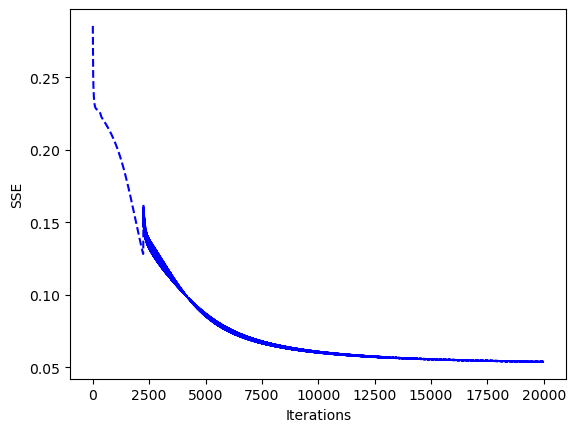

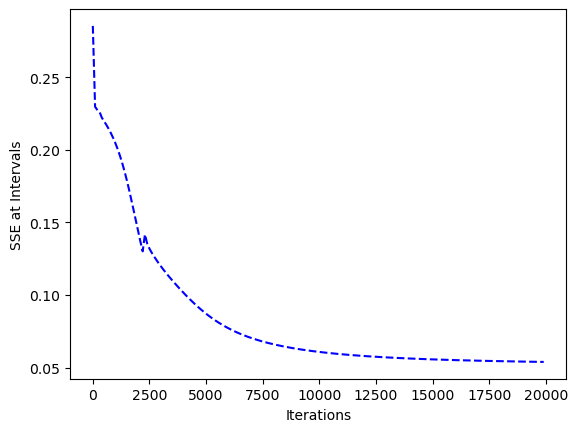

In [14]:
plt.plot(range(len(loss)), loss, '--b')
plt.xlabel("Iterations")
plt.ylabel("SSE")
plt.show()

interval = 100
plt.plot(range(0, len(loss), interval), loss[::interval], '--b')
plt.xlabel("Iterations")
plt.ylabel("SSE at Intervals")
plt.show()

In [15]:
A1_test, A2_test = vectorized_forward_propagation(X_test, parameters)
predictions = A2_test > 0.5
accuracy = np.mean(predictions == y_test)
print(f"Accuracy on the test set: {accuracy:.2f}")

Accuracy on the test set: 0.89


#### Conclusion:
Adjusting Iterations and Learning Rate led to an overall better result, indicated by lower fluctuations in loss as well as a higher accuracy.

## References

Battiti, R. (1994). Using mutual information for selecting features in supervised neural net learning. IEEE Transactions on neural networks, 5(4), 537-550.

Fausser, S (2023). Artificial neural networks and classification metrics. Elearning University of Applied Sciences Neu-Ulm.